In [97]:
#import packages
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
import sklearn
import numpy as np
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder 
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2, l1
from keras.optimizers import SGD
np.random.seed(47)
from sklearn.decomposition import PCA

#import dataset
texts = pd.read_csv('Textdata.csv')
print(texts.head())
print(texts.tail())



  category                                               text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
     category                                               text
5567     spam  This is the 2nd time we have tried 2 contact u...
5568      ham               Will ü b going to esplanade fr home?
5569      ham  Pity, * was in mood for that. So...any other s...
5570      ham  The guy did some bitching but I acted like i'd...
5571      ham                         Rofl. Its true to its name


In [98]:
#change category to numerical column
le = LabelEncoder() 
  
texts['category']= le.fit_transform(texts['category'])

texts.head()

,category,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [99]:
#text before preprocessing
texts.iloc[0][1]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [100]:
#processing the text data
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

texts['text'] = texts['text'].apply(preprocessor)

In [101]:
#text after processing
texts.iloc[0][1]

'go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat '

In [102]:
#count by their category
texts.groupby('category').describe()

text                                                               
         count unique                                                top freq
category                                                                     
0         4825   4506                              sorry i ll call later   30
1          747    638  please call our customer service representativ...    4

In [103]:
#create text length category
texts['length'] = texts['text'].map(lambda text: len(text))
print(texts.head())

   category                                               text  length
0         0  go until jurong point crazy available only in ...     103
1         0                           ok lar joking wif u oni       24
2         1  free entry in 2 a wkly comp to win fa cup fina...     154
3         0       u dun say so early hor u c already then say       44
4         0  nah i don t think he goes to usf he lives arou...      60


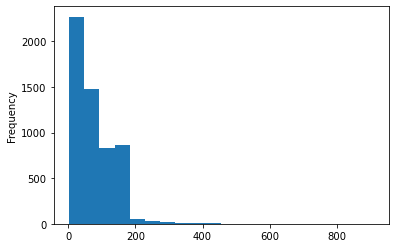

In [104]:
#create histogram of text lengths
texts.length.plot(bins=20, kind='hist')

In [105]:
#description of text lenghts
texts.length.describe()

count    5572.000000
mean       77.417624
std        57.310303
min         2.000000
25%        34.000000
50%        59.000000
75%       117.000000
max       908.000000
Name: length, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa2803dff40>,
      dtype=object)

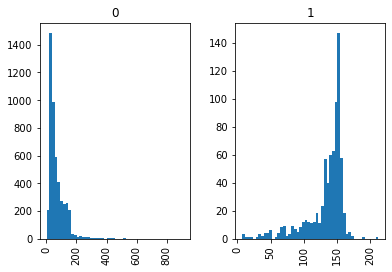

In [106]:
#create histograms based on real/spam texts and their length
texts.hist(column='length', by='category', bins=50)

In [107]:
# convert bytes into proper unicode
def split_into_tokens(text):
    text = str(text) 
    return TextBlob(text).words

In [108]:
#split the text message into individual words
texts.text.head().apply(split_into_tokens)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, don, t, think, he, goes, to, usf, he,...
Name: text, dtype: object

In [109]:
# list of (word, POS) pairs
TextBlob("hello world, how is it going?").tags

[('hello', 'JJ'),
 ('world', 'NN'),
 ('how', 'WRB'),
 ('is', 'VBZ'),
 ('it', 'PRP'),
 ('going', 'VBG')]

In [110]:
#import new package for stopwords
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = stopwords.words('english')
stop = stop + [u'a',u'b',u'c',u'd',u'e',u'f',u'g',u'h',u'i',u'j',u'k',u'l',u'm',u'n',u'o',u'p',u'q',u'r',u's',u't',u'v',u'w',u'x',u'y',u'z']

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/coreyyesavage/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [111]:
# for each word, take its "base form" = lemma 
def split_into_lemmas(text):
    text= str(text).lower()
    words = TextBlob(text).words
    return [word.lemma for word in words if word not in stop]

texts.text.head().apply(split_into_lemmas)

0    [go, jurong, point, crazy, available, bugis, g...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3           [u, dun, say, early, hor, u, already, say]
4          [nah, think, go, usf, life, around, though]
Name: text, dtype: object

In [112]:
# Stochastic Logistic Regression
model = Sequential()

# validation loss 
model.add(Dense(units=1, input_shape=[1], 
                activation='sigmoid', kernel_regularizer=l1(0.01)))

# Compile model
sgd = SGD(lr=0.1)
model.compile(loss='mean_squared_error', optimizer=sgd)

In [113]:
#summary of our model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [114]:
#create arrays for our columns
X = np.array(texts['category']).reshape(-1,1)
y = np.array(texts['text'])


In [117]:
#split our data into test and train sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 10)

In [118]:
#feature scaling
stdscaler = preprocessing.StandardScaler().fit(X_train)
X_scaled  = stdscaler.transform(X)
X_train_scaled = stdscaler.transform(X_train)
X_test_scaled  = stdscaler.transform(X_test)

In [119]:
#principle component analysis

pca = PCA()
X_train_pca = pca.fit_transform(X_train)
pca.explained_variance_ratio_

array([1.])

In [121]:
#split test and train based on columns
X_train,X_test,y_train,y_test = train_test_split(texts["text"],texts["category"], test_size = 0.2, random_state = 5)

In [122]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

In [123]:
X_train_texts = vect.transform(X_train)
X_test_texts = vect.transform(X_test)
type(X_train_texts)

scipy.sparse.csr.csr_matrix

## Logistic Regression

In [124]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_texts,y_train)

LogisticRegression()

In [125]:
prediction = dict()

prediction["Logistic"] = model.predict(X_test_texts)

In [127]:
#accuracy of logistic regression
accuracy_score(y_test,prediction["Logistic"])

0.9874439461883409

In [139]:
#precision, recall, f1, and support of logistic regression
print("Logistic Results\nConfusion Matrix: ")
print(confusion_matrix(y_test,predicted))
print(classification_report(y_test,prediction["Logistic"]))

Logistic Results
Confusion Matrix: 
[[968   2]
 [ 24 121]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       970
           1       0.99      0.92      0.95       145

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



## Decision Tree

In [148]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree

max_depths = range(1,300,1)

dtc = tree.DecisionTreeClassifier(criterion='entropy')
grid = GridSearchCV(estimator=dtc, param_grid=dict(max_depth=max_depths),cv=3)
grid.fit(X_train_texts, y_train)

print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.max_depth)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': range(1, 300)})
0.9625304941141639
199


In [131]:
predicted = grid.predict(X_test_texts)

print("Decision Tree Results\nConfusion Matrix: ")
print(confusion_matrix(y_test,predicted))
print("\n Classifcation Report")
print(classification_report(y_test,predicted))

Decision Tree Results
Confusion Matrix: 
[[961   9]
 [ 24 121]]

 Classifcation Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       970
           1       0.93      0.83      0.88       145

    accuracy                           0.97      1115
   macro avg       0.95      0.91      0.93      1115
weighted avg       0.97      0.97      0.97      1115



## Random Forest

In [132]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

n_estimators_list = [5,10,50,100,200,300,400,1000]

rfc = RandomForestClassifier(random_state=47)
grid = GridSearchCV(estimator=rfc, param_grid=dict(n_estimators=n_estimators_list),cv=3)
grid.fit(X_train_texts, y_train)

print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.n_estimators)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=47),
             param_grid={'n_estimators': [5, 10, 50, 100, 200, 300, 400, 1000]})
0.9703830589429513
300


In [146]:
predicted = grid.predict(X_test_texts)

print("Random Forest Results\nConfusion Matrix: ")
print(confusion_matrix(y_test,predicted))
print("\n Classifcation Report")
print(classification_report(y_test,predicted))

Random Forest Results
Confusion Matrix: 
[[968   2]
 [ 24 121]]

 Classifcation Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       970
           1       0.98      0.83      0.90       145

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.94      1115
weighted avg       0.98      0.98      0.98      1115



## Extra trees Classifier

In [142]:
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV


n_estimators_list = [5,10,50,100,200,300,400,1000]

etc = ExtraTreesClassifier(random_state=47)
grid = GridSearchCV(estimator=etc, param_grid=dict(n_estimators=n_estimators_list),cv=3)
grid.fit(X_train_texts, y_train)

print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.n_estimators)

GridSearchCV(cv=3, estimator=ExtraTreesClassifier(random_state=47),
             param_grid={'n_estimators': [5, 10, 50, 100, 200, 300, 400, 1000]})
0.9737482496567288
400


In [143]:
predicted = grid.predict(X_test_texts)

print("Extra Tree Results\nConfusion Matrix: ")
print(confusion_matrix(y_test,predicted))
print("\n Classifcation Report")
print(classification_report(y_test,predicted))

Extra Tree Results
Confusion Matrix: 
[[970   0]
 [ 18 127]]

 Classifcation Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       970
           1       1.00      0.88      0.93       145

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



## Gradient Boost

In [144]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=47)

n_estimators_list = [5,10,50,100,200,300,400,1000]
grid = GridSearchCV(estimator=gbc, param_grid=dict(n_estimators=n_estimators_list),cv=3)
grid.fit(X_train_texts, y_train)

print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.n_estimators)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=47),
             param_grid={'n_estimators': [5, 10, 50, 100, 200, 300, 400, 1000]})
0.9737484007111643
1000


In [145]:
predicted = grid.predict(X_test_texts)

print("Gradient Boost Results\nConfusion Matrix: ")
print(confusion_matrix(y_test,predicted))
print("\n Classifcation Report")
print(classification_report(y_test,predicted))

Gradient Boost Results
Confusion Matrix: 
[[968   2]
 [ 24 121]]

 Classifcation Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       970
           1       0.98      0.83      0.90       145

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.94      1115
weighted avg       0.98      0.98      0.98      1115

